---

# NLP PROJECT: Sentiment Analysis for domain-specific texts 

#### [[💻Github ](https://github.com/pbozoglou/Sentiment-Analysis-applied-in-the-hospitality-domain)] [[📈Dataset ](https://uniwagr-my.sharepoint.com/:x:/g/personal/aivc24012_uniwa_gr/EbnCHEtaIAhCgwerFf85NIoB3trH4MTmmj3b4W_Y3rLX4Q?e=e5FlU1)]

## Milestones
- [Domain Selection and Dataset Creation](#Domain-Selection-and-Dataset-Creation)
- [Preprocessing and Text Analysis](#Preprocessing-and-Text-Analysis)
- [Baseline Model Development](#Baseline-Model-Development)
- [Deep Learning Model Development](#Deep-Learning-Model-Development)
- [Evaluation, Performance Analysis and Visualization](#Evaluation,-Performance-Analysis-and-Visualization)
- [References](#References)

---

## Domain Selection and Dataset Creation

The domain selected for this project is hospitality / hotel reviews. Specifically, a dataset of reviews from lodgings in the city of Athens, collected using the Google Places API. Sentiment analysis is important in this domain for understanding and analysing customer satisfaction.

In this section we will import the necessary libraries and visualize the collected dataset.

In [68]:
from utils.utils import *
from PIL import Image
import nltk
import time
import re
import emoji

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import geopandas as gpd
import contextily as ctx

from IPython.display import HTML

from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist, pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer

import sklearn
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, LSTM, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing import sequence

pd.set_option('display.max_colwidth', 15)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [69]:
reviews = pd.read_csv("../datasets/reviews_athens.csv")
dataset = reviews.copy()[["user_rating","review_text","location.lat","location.lng"]]
print(dataset.info())
print(dataset.head())
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5623 entries, 0 to 5622
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_rating   5623 non-null   int64  
 1   review_text   5623 non-null   object 
 2   location.lat  5623 non-null   float64
 3   location.lng  5623 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 175.8+ KB
None
   user_rating     review_text  location.lat  location.lng
0            5  Feels like ...     38.013307     23.677931
1            5  This is a h...     38.013307     23.677931
2            5  Very nice p...     38.013307     23.677931
3            5  Amazing app...     38.013307     23.677931
4            5  The best pl...     38.013307     23.677931
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


In the cell below, we convert the ratings to *positive* and *negative* sentiment and visualize the dataset sentiment & rating distribution:

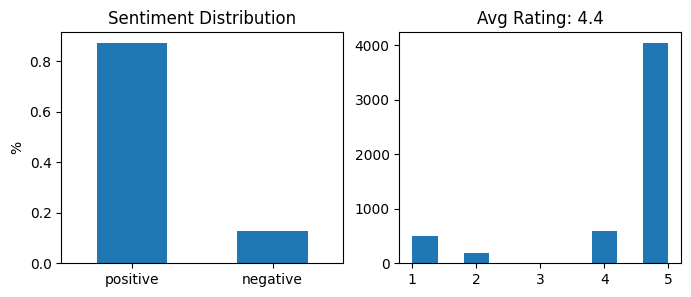

In [70]:
_, ax1 = plt.subplots(nrows=1,ncols=2,figsize=(8,3))

dataset.loc[dataset.user_rating <= 3,'sentiment'] = 'negative'
dataset.loc[dataset.user_rating > 3,'sentiment'] = 'positive'
dataset.drop(index=dataset[dataset.user_rating==3].index, inplace=True)

t1='Average Rating: {}'.format(round(dataset.user_rating.mean(),2))
dataset.sentiment.value_counts(True).plot(kind='bar',ax=ax1[0],subplots=True,rot=0)
dataset.user_rating.plot(kind='hist',ax=ax1[1],subplots=True)
ax1[0].set_xlabel('')
ax1[0].set_ylabel('%')
ax1[0].set_title('Sentiment Distribution')
ax1[1].set_ylabel('')
ax1[1].set_title('Avg Rating: {}'.format(dataset.user_rating.mean().round(1)));

**⚠️ Note:** Positive sentiment is dominant in the data (more than 80%).

To fix that, we undersample the dataset by randomly dropping positive-sentiment rows to have a 1:1 distribution:

In [71]:
np.random.seed(42)

# Number of positives to drop
dx = dataset.sentiment.value_counts().positive - dataset.sentiment.value_counts().negative

# Generate random index pointing to positive reviews
random_positives_index = np.random.choice(dataset[dataset.sentiment=='positive'].index, dx, replace=False)

# Drop data based on the generated index
dataset = dataset.drop(index=random_positives_index)
print('Final Dataset:')
dataset

Final Dataset:


,user_rating,review_text,location.lat,location.lng,sentiment
4,5,The best pl...,38.013307,23.677931,positive
6,1,Total lack ...,38.008708,23.671713,negative
8,1,The camping...,38.008708,23.671713,negative
9,1,Our experie...,38.008708,23.671713,negative
12,5,Great hospi...,38.003389,23.678001,positive
...,...,...,...,...,...
5575,4,Apartment f...,37.921977,23.697787,positive
5606,5,Great houst...,37.912964,23.737785,positive
5608,1,**AVOID** t...,37.912964,23.737785,negative
5615,5,We had a wo...,37.907421,23.749808,positive


To verify that it is now evenly distributed, we explore the dataset again below:

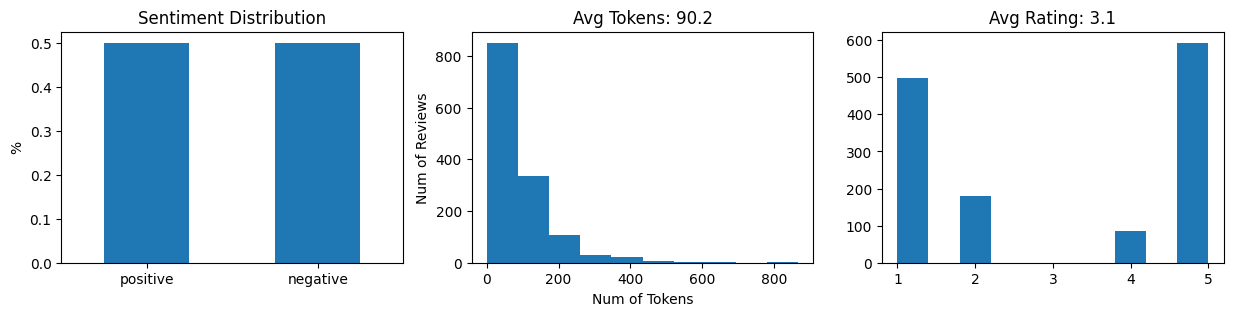

In [72]:
_, ax2 = plt.subplots(nrows=1,ncols=3,figsize=(15,3))

dataset.sentiment.value_counts(True).plot(kind='bar',ax=ax2[0],subplots=True,rot=0)
dataset.review_text.apply(word_tokenize).apply(len).plot(kind='hist',ax=ax2[1],subplots=True)
dataset.user_rating.plot(kind='hist',ax=ax2[2],subplots=True)

ax2[0].set_title('Sentiment Distribution')
ax2[0].set_xlabel('')
ax2[0].set_ylabel('%')
ax2[1].set_title('Avg Tokens: {}'.format(dataset.review_text.apply(word_tokenize).apply(len).mean().round(1)))
ax2[1].set_ylabel('Num of Reviews')
ax2[1].set_xlabel('Num of Tokens')
ax2[2].set_ylabel('')
ax2[2].set_title('Avg Rating: {}'.format(dataset.user_rating.mean().round(1)));

---

## Preprocessing and Text Analysis

In this section we will clean and prepare the dataset for modeling.

First we drop any duplicate & missing values:

In [73]:
# Non for this dataset
# dataset.drop_duplicates(inplace=True)
# dataset.dropna(inplace=True)

Next, we perform text cleaning: remove noise, handle emojis, stop words, and other irrelevant tokens. [[🔗#1](https://www.geeksforgeeks.org/text-preprocessing-for-nlp-tasks/)] [[🔗#2](https://medium.com/sciforce/text-preprocessing-for-nlp-and-machine-learning-tasks-3e077aa4946e)]

In [74]:
stopwords_eng = set(stopwords.words('english'))
stopwords_eng.remove('not')
lemmatizer = WordNetLemmatizer()
words = set(nltk.corpus.words.words())

def clean(txt:str)->str:
    txt = emoji.demojize(txt).lower()
    txt = re.sub(r'[^\w\s]|\d+', '', txt)
    txt = ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(txt) if w not in stopwords_eng and w in words])
    return re.sub(r'\n| +',' ',txt).strip()

dataset["review_text_cleaned"] = dataset.review_text.apply(clean)

print("BEFORE CLEAN: ",dataset.review_text.iloc[0])
print("\nAFTER CLEAN: ",dataset.review_text_cleaned.iloc[0])
print("\nAVG TOKENS BEFORE & AFTER CLEAN:\n{before:.2f} -> {after:.2f}".format(
    before=dataset.review_text.apply(word_tokenize).apply(len).mean(), 
    after=dataset.review_text_cleaned.apply(word_tokenize).apply(len).mean())
)

BEFORE CLEAN:  The best place in Athens!

AFTER CLEAN:  best place

AVG TOKENS BEFORE & AFTER CLEAN:
90.25 -> 32.97


Lastly, we tokenize and vectorize the data using the TF-IDF vectorizer:

In [75]:
# Tokenize data and remove rows with <1 tokens.
dataset['tokens'] = dataset.review_text_cleaned.apply(word_tokenize)
dataset.drop(index=dataset[dataset.tokens.apply(len)<1].index,inplace=True)

# Encode sentiment to 0 or 1 values.
dataset['encoded_sentiment'] = [1 if i=="positive" else 0 for i in dataset.sentiment]

# Split data for training and testing.
indices = np.arange(len(dataset.review_text_cleaned.to_numpy()))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    dataset.review_text_cleaned.to_numpy(), 
    dataset.encoded_sentiment.to_numpy(), 
    indices,
    random_state=42, 
    test_size=0.2
)
print(f"Train_Samples:{X_train.shape}, Test_Samples:{X_test.shape}")

# Vectorize the data using TF-IDF
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(X_train).todense()
x_test = vectorizer.transform(X_test).todense()

Train_Samples:(1078,), Test_Samples:(270,)


Visualization of some reviews before and after cleaning:

In [76]:
print("Example cleaned texts:")
for i in dataset.head(2)[["review_text","review_text_cleaned","tokens"]].values:
    print(i[0],"\n->\n",i[1],'\n')

Example cleaned texts:
The best place in Athens! 
->
 best place 

Total lack of hospitality and respect for a bicycle camper.
The campsite was almost completely empty. And yet I should have made a reservation. I'd never heard that before.  There was only one night available on this empty campsite!
There is always a place for bicycle campers It is an unwritten rule.
I was assigned a spot of 2 square meters. Because it was not level, I moved a small meter. Then a  witch from One Flew over the Cuckoos Nest came and told me to just follow the instructions. I packed my things and left. 
->
 total lack hospitality respect bicycle camper almost completely empty yet made reservation id never one night available empty always place bicycle unwritten rule assigned spot square not level small meter witch one flew nest came told follow left 



The dataset is now cleaned and handled of any domain-specific linguistic (slang, emojis, punctuation spam, 2+ whitepaces, ...). Below we save the preprocessed dataset and is now ready for modelling:

In [77]:
# Save preprocessed dataset
# dataset.to_csv("preprocessed_dataset.csv",index=False)

Next, we prepare a dataframe in which we will store all the metrics of each model for later evaluation and visualizations:

In [78]:
# Define models to train
names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear", "LSTM", "CNN"]

# Define array to keep track of all models performance
all_models_results = pd.DataFrame([], columns = ["Y_true","Y_pred","train_time","precision","recall","f1-score","accuracy"], index=names)

---

## Baseline Model Development

In this section we train several baseline models, plot the confusion matrixes and store the metrics of each model.
We choose to train on several baseline models and see how each performs for this domain.

In [79]:
# Initialize the models to train
classifiers = [
    KNeighborsClassifier(n_neighbors=64), # 64 worked best after running several parameters
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)
for name, model in models:
    t1=time.time()
    print(f"Training {name}...")
    model.fit(np.asarray(x_train),y_train)
    preds = model.predict(np.asarray(x_test))    

    all_models_results.loc[name,'Y_true'] = y_test
    all_models_results.loc[name,'Y_pred'] = preds
    all_models_results.loc[name,'train_time'] = time.time()-t1
    all_models_results.loc[name,'precision'] = sklearn.metrics.precision_score(y_test,preds)
    all_models_results.loc[name,'recall'] = sklearn.metrics.recall_score(y_test,preds)
    all_models_results.loc[name,'f1-score'] = sklearn.metrics.f1_score(y_test,preds)
    all_models_results.loc[name,'accuracy'] = sklearn.metrics.accuracy_score(y_test,preds)

    print(confusion_matrix(y_test, preds),'\n')
    
all_models_results

Training K Nearest Neighbors...
[[120  10]
 [  8 132]] 

Training Decision Tree...
[[102  28]
 [ 24 116]] 

Training Random Forest...
[[121   9]
 [  5 135]] 

Training Logistic Regression...
[[123   7]
 [  7 133]] 

Training SGD Classifier...
[[122   8]
 [  8 132]] 

Training Naive Bayes...
[[125   5]
 [  6 134]] 

Training SVM Linear...
[[124   6]
 [  7 133]] 



,Y_true,Y_pred,train_time,precision,recall,f1-score,accuracy
K Nearest Neighbors,"[1, 0, 0, 1...","[1, 0, 1, 0...",0.261795,0.929577,0.942857,0.93617,0.933333
Decision Tree,"[1, 0, 0, 1...","[0, 0, 1, 0...",0.848472,0.805556,0.828571,0.816901,0.807407
Random Forest,"[1, 0, 0, 1...","[1, 0, 0, 0...",2.358644,0.9375,0.964286,0.950704,0.948148
Logistic Regression,"[1, 0, 0, 1...","[0, 0, 0, 0...",0.136283,0.95,0.95,0.95,0.948148
SGD Classifier,"[1, 0, 0, 1...","[1, 0, 0, 0...",0.228299,0.942857,0.942857,0.942857,0.940741
Naive Bayes,"[1, 0, 0, 1...","[0, 0, 0, 1...",0.030625,0.964029,0.957143,0.960573,0.959259
SVM Linear,"[1, 0, 0, 1...","[1, 0, 0, 0...",4.355294,0.956835,0.95,0.953405,0.951852
LSTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The baseline models show great performance for this dataset both in train time and accuracy, which may be due to the inadequate size (1358 rows).

---

## Deep Learning Model Development

For deep learning, we prepare the data using a max length of 60 tokens and convert them to sequences using the keras tokenizer fitted with max 1000 features (words). For longer or shorted text we apply post padding/truncating using the pad_sequences function.

In [80]:
maxlen = 60
max_features = 1000
embedding_dims = 50

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen,padding='post',truncating='post')
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen,padding='post',truncating='post')

**METHOD 1: LSTM model [(🔗Source)](https://www.tensorflow.org/text/tutorials/text_classification_rnn)**

In the below cell we build and compiles an LSTM model of 128 units and summarize the model architecture:

In [81]:
lstm_model = Sequential([
    tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32),
    tf.keras.layers.Embedding(max_features,embedding_dims),
    LSTM(128),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1,activation='sigmoid')
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 60, 50)              │          50,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,969 (585.82 KB)

 Trainable params: 149,969 (585.82 KB)

 Non-trainable params: 0 (0.00 B)

Since the model is compiled, we can start trainning: 

In [82]:
t1=time.time()
history = lstm_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)
all_models_results.loc['LSTM','train_time'] = time.time()-t1

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.4821 - loss: 0.6938 - val_accuracy: 0.4907 - val_loss: 0.6934
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5576 - loss: 0.6930 - val_accuracy: 0.5185 - val_loss: 0.6933
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5523 - loss: 0.6914 - val_accuracy: 0.5185 - val_loss: 0.6935
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5594 - loss: 0.6916 - val_accuracy: 0.5370 - val_loss: 0.6931
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5651 - loss: 0.6889 - val_accuracy: 0.5324 - val_loss: 0.6927
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5830 - loss: 0.6848 - val_accuracy: 0.5556 - val_loss: 0.6781
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.6712 - loss: 0.6395 - val_accuracy: 0.8056 - val_loss: 0.5053
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.8454 - loss: 0.4239 - val_accuracy: 0

In [83]:
loss, accuracy = lstm_model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9272 - loss: 0.2185
Test Accuracy: 92.22%


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Y_true        [1, 0, 0, 1...
Y_pred        [0, 0, 1, 1...
train_time         38.197624
precision           0.910345
recall              0.942857
f1-score            0.926316
accuracy            0.922222
Name: LSTM, dtype: object


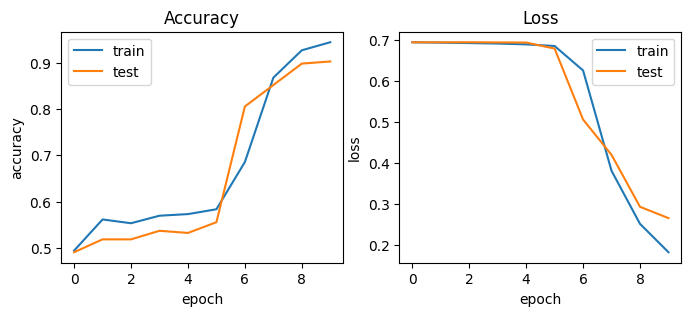

In [84]:
name = 'LSTM'

preds = lstm_model.predict(x_test).round().astype(int).flatten()

all_models_results.loc[name,'Y_true'] = y_test
all_models_results.loc[name,'Y_pred'] = preds
all_models_results.loc[name,'precision'] = sklearn.metrics.precision_score(y_test,preds)
all_models_results.loc[name,'recall'] = sklearn.metrics.recall_score(y_test,preds)
all_models_results.loc[name,'f1-score'] = sklearn.metrics.f1_score(y_test,preds)
all_models_results.loc[name,'accuracy'] = sklearn.metrics.accuracy_score(y_test,preds)
print(all_models_results.T['LSTM'])
confusion_matrix(y_test,preds)
plot_hist(history)

**METHOD 2: CNN model [🔗Source](https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9)**

We follow the same pattern/steps for the CNN model below:

In [85]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32),
    tf.keras.layers.Embedding(max_features,embedding_dims),
    tf.keras.layers.Conv1D(250, 3, padding='valid', activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 60, 50)              │          50,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 58, 250)             │          37,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 58, 250)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 250)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,751 (588.87 KB)

 Trainable params: 150,751 (588.87 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
t1=time.time()
history = cnn_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)
all_models_results.loc['CNN','train_time'] = time.time()-t1

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5074 - loss: 0.6943 - val_accuracy: 0.5602 - val_loss: 0.6894
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5675 - loss: 0.6882 - val_accuracy: 0.6204 - val_loss: 0.6867
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6445 - loss: 0.6838 - val_accuracy: 0.6759 - val_loss: 0.6843
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6742 - loss: 0.6778 - val_accuracy: 0.7037 - val_loss: 0.6795
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7049 - loss: 0.6679 - val_accuracy: 0.7130 - val_loss: 0.6713
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7318 - loss: 0.6573 - val_accuracy: 0.7407 - val_loss: 0.6604
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7418 - loss: 0.6376 - val_accuracy: 0.7731 - val_loss: 0.6433
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7937 - loss: 0.6039 - val_accuracy: 0.7963 - v

In [87]:
loss, accuracy = cnn_model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9100 - loss: 0.2691
Test Accuracy: 92.59%


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Y_true        [1, 0, 0, 1...
Y_pred        [0, 0, 0, 0...
train_time         23.231241
precision           0.941176
recall              0.914286
f1-score            0.927536
accuracy            0.925926
Name: CNN, dtype: object


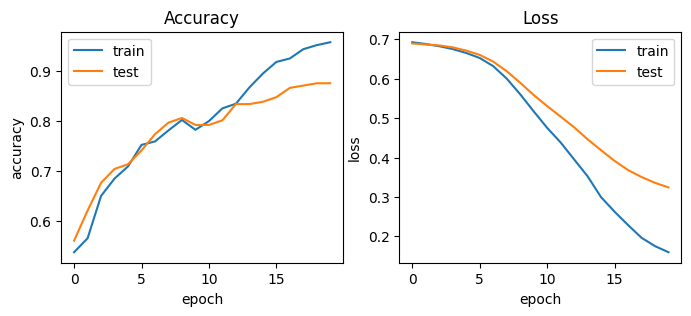

In [88]:
name = 'CNN'

preds = cnn_model.predict(x_test).round().astype(int).flatten()

all_models_results.loc[name,'Y_true'] = y_test
all_models_results.loc[name,'Y_pred'] = preds
all_models_results.loc[name,'precision'] = sklearn.metrics.precision_score(y_test,preds)
all_models_results.loc[name,'recall'] = sklearn.metrics.recall_score(y_test,preds)
all_models_results.loc[name,'f1-score'] = sklearn.metrics.f1_score(y_test,preds)
all_models_results.loc[name,'accuracy'] = sklearn.metrics.accuracy_score(y_test,preds)
print(all_models_results.T['CNN'])
confusion_matrix(y_test,preds)
plot_hist(history)

The deep learning models perform great, but relatively to the baseline they take much longer to train and have almost the same level of accuracy. Of course this result can differ if applied in a larger dataset. In the next section, we will take a closer look at the performance of each model and evaluate them.

---

## Evaluation, Performance Analysis and Visualization

We now have trained all the models, next step is to visualize and analyze the results. Below is a performance comparison heatmap of all the models used in this project:

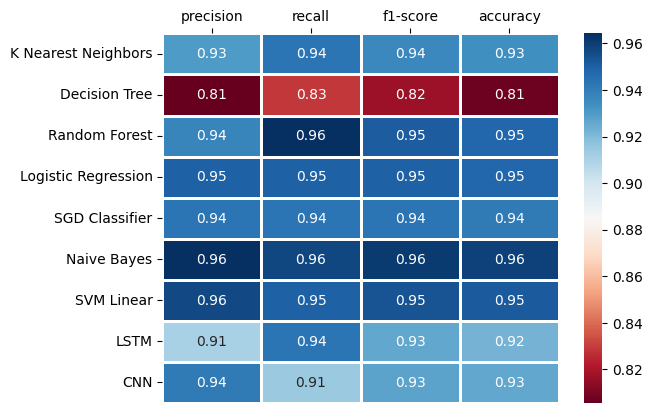

In [89]:
ax = sns.heatmap(all_models_results[["precision","recall","f1-score","accuracy"]].astype(float),annot=True,linewidths=1,cmap='RdBu');
ax.xaxis.tick_top()

Plotting another heatmap of each model train times:

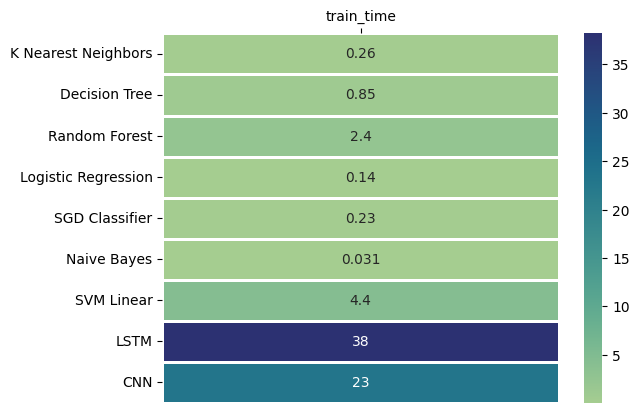

In [90]:
ax = sns.heatmap(all_models_results[['train_time']].astype(float),annot=True,linewidths=1,cmap='crest');
ax.xaxis.tick_top()

**Misclassification Analysis**

Below we collect all the falsely predicted test samples by each model and visualize them in a bar-plot:

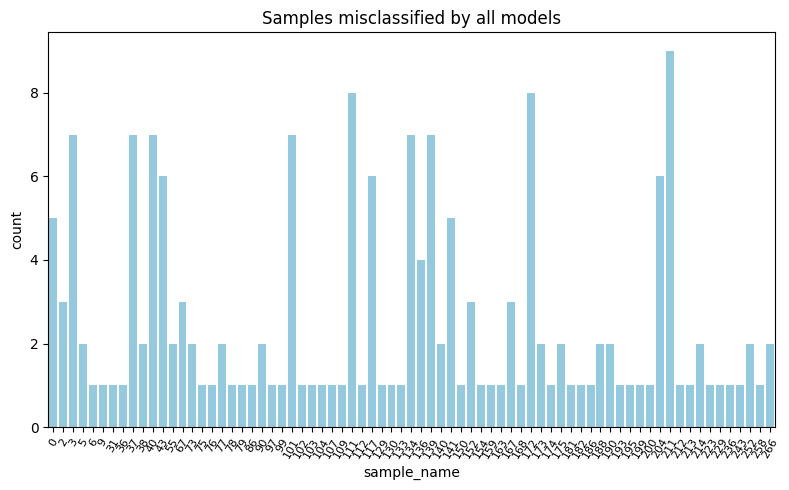

In [91]:
# Get all false predictions from all models
wrong_preds = get_false_predictions(all_models_results)

# Calculate the frequency of each false prediction
f = dict()
for i in wrong_preds:
    if str(i) not in f:f[str(i)] = 1
    else:f[str(i)] +=1

# Plot false predictions
plt.figure(figsize=(8,5))
sns.barplot(x=list(f.keys()),y=list(f.values()),color='skyblue');
plt.xticks(rotation=60,fontsize=8)
plt.xlabel("sample_name")
plt.ylabel("count")
plt.title("Samples misclassified by all models")
plt.tight_layout()
plt.show()

Top 5 misclassified test samples:

In [92]:
top_false = sorted(f.items(), key=lambda x: x[1])[-5:]
print("Top 5 misclassified test samples:")
for i in top_false:
    print("\n\t-Text: ", ' '.join(dataset.tokens.iloc[indices_test[int(i[0])]]))
    print(f"\t-Misclassified by {i[1]}/9 models.")

Top 5 misclassified test samples:

	-Text:  eaten need go hospital place must close law
	-Misclassified by 7/9 models.

	-Text:  late night staff waiting u apartment away hotel reception fact taking u apartment not reception luckily clerk caught u elevator apartment building handle u luggage luckily set return bottom floor problem three sent luggage elevator room comfortable clean good great shower plenty hot water small kitchen cutlery morning head airport
	-Misclassified by 7/9 models.

	-Text:  remarkable people respect
	-Misclassified by 8/9 models.

	-Text:  bathroom level unclean unhygienic lot mould ceiling low price accommodation decent fine short stay nice addition acropolis also nice man received u check
	-Misclassified by 8/9 models.

	-Text:  welcome car lady responsible way better doesnt reflect ethos hotel give bar staff ordered got first second drink wrong lovely rum returned got back right cork residue drink bar staff lovely helpful little matter level must visiting sta

**Model misclassification and infuential words analysis**

In [93]:
all_pos=[]
all_neg=[]

Logistic Regression influential words and performance on the top misclassed test samples (colours are visible if opened in an IDE) :

In [94]:
model_index=3

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get weights of the model
coefficients = classifiers[model_index].coef_[0]

# Sort feature names by weight
word_importance = dict(zip(feature_names, coefficients))
sorted_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)

# Keep positives and negatives
for i in range(15):
    all_pos.append(sorted_words[i][0]) 
    all_neg.append(sorted_words[-i][0])

print([i[0] for i in sorted_words[:10]])
print([i[0] for i in sorted_words[-10:]])

# Display colored misclassifications
bound= min(abs(coefficients.max()),abs(coefficients.min()))
print("\nWeights of Logistic Regression on misclassified samples: \n")
for index,count in top_false[-5:]:
    i_importance = [word_importance[j] if j in feature_names else 0.0 for j in dataset.tokens.iloc[indices_test[int(index)]]]
    colors = colorize(i_importance, cmin=-bound,cmax=bound, cmap='PiYG')
    print(f"•Sample {i}: predicted label {all_models_results.iloc[model_index].Y_pred[int(index)]}, True label {all_models_results.iloc[model_index].Y_true[int(index)]}")
    print("•Original text: ",dataset.review_text.iloc[indices_test[int(index)]])
    display(HTML("".join(list(map(hlstr, dataset.tokens.iloc[indices_test[int(index)]], colors[:-2])))))
    print('\n')

['clean', 'great', 'nice', 'excellent', 'perfect', 'amazing', 'acropolis', 'best', 'comfortable', 'friendly']
['horrible', 'avoid', 'terrible', 'didnt', 'dont', 'sleep', 'worst', 'dirty', 'bad', 'not']

Weights of Logistic Regression on misclassified samples: 

•Sample 14: predicted label 1, True label 0
•Original text:  (-)5 stars!! I was eaten by bedbugs. Now i need to go on a hospital! This place must close by LAW!




•Sample 14: predicted label 0, True label 1
•Original text:  Arrived late night, staff was waiting for us. The apartment was a few blocks away from the hotel reception, in fact google maps was taking us to the apartment and not to reception. Luckily the clerk caught us before we walked by. Elevator in the apartment building couldn’t handle both of us and our luggage. Luckily it was set to return to the bottom floor if it had a problem. We walked up the three flights of stairs but sent our luggage in the elevator. The room was comfortable and clean with good AC and a great shower with plenty of hot water. There was a small kitchen with cutlery and dishes. We walked to the M3 in the morning to head to the airport.




•Sample 14: predicted label 0, True label 1
•Original text:  Remarkable people who respect their patients!!!




•Sample 14: predicted label 1, True label 0
•Original text:  The shared bathroom on level 2 is very unclean and unhygienic, lots of mould on the ceiling. But for the low price the accommodation is decent and very fine for a short stay. The rooftop is a nice addition with views of the acropolis! :) Also a very nice man who received us at check in.




•Sample 14: predicted label 1, True label 0
•Original text:  The welcome to the car from the lady responsible should be way better and doesn't reflect the ethos that the hotel tries to give. The bar staff was overwhelmed with ordered and got my first and second drink wrong. Ordering a lovely rum, that I returned and then I got it back right but there was cork residue in the drink. Bar staff where lovely and helpful but it's the little things that matter on that level. Overall...great view...a must if you're visiting Athens and stay in that area.


We do the same for the SDG classifier: influential words and performance of the top misclassed test samples (colours are visible if opened in an IDE):

In [95]:
model_index=4
false_predictions = np.where(all_models_results.iloc[model_index].Y_true != all_models_results.iloc[model_index].Y_pred)

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get weights of the model
coefficients = classifiers[model_index].coef_[0]

# Sort feature names by weight
word_importance = dict(zip(feature_names, coefficients))
sorted_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)

# Keep positives and negatives
for i in range(15):
    all_pos.append(sorted_words[i][0]) 
    all_neg.append(sorted_words[-i][0])

print([i[0] for i in sorted_words[:10]])
print([i[0] for i in sorted_words[-10:]])

# Display colored misclassifications
bound= min(abs(coefficients.max()),abs(coefficients.min()))
print("\nWeights of Logistic Regression on misclassified samples: \n")
for index,count in top_false[-5:]:
    i_importance = [word_importance[j] if j in feature_names else 0.0 for j in dataset.tokens.iloc[indices_test[int(index)]]]
    colors = colorize(i_importance, cmin=-bound, cmax=bound, cmap='PiYG')
    print(f"•Sample {i}: predicted label {all_models_results.iloc[model_index].Y_pred[int(index)]}, True label {all_models_results.iloc[model_index].Y_true[int(index)]}")
    print("•Original text: ",dataset.review_text.iloc[indices_test[int(index)]])
    display(HTML("".join(list(map(hlstr, dataset.tokens.iloc[indices_test[int(index)]], colors[:-2])))))
    print('\n')

['nice', 'great', 'excellent', 'spacious', 'perfect', 'clean', 'best', 'easy', 'medical', 'comfortable']
['sleep', 'poor', 'avoid', 'horrible', 'worst', 'going', 'dirty', 'bad', 'wasnt', 'not']

Weights of Logistic Regression on misclassified samples: 

•Sample 14: predicted label 0, True label 0
•Original text:  (-)5 stars!! I was eaten by bedbugs. Now i need to go on a hospital! This place must close by LAW!




•Sample 14: predicted label 1, True label 1
•Original text:  Arrived late night, staff was waiting for us. The apartment was a few blocks away from the hotel reception, in fact google maps was taking us to the apartment and not to reception. Luckily the clerk caught us before we walked by. Elevator in the apartment building couldn’t handle both of us and our luggage. Luckily it was set to return to the bottom floor if it had a problem. We walked up the three flights of stairs but sent our luggage in the elevator. The room was comfortable and clean with good AC and a great shower with plenty of hot water. There was a small kitchen with cutlery and dishes. We walked to the M3 in the morning to head to the airport.




•Sample 14: predicted label 0, True label 1
•Original text:  Remarkable people who respect their patients!!!




•Sample 14: predicted label 1, True label 0
•Original text:  The shared bathroom on level 2 is very unclean and unhygienic, lots of mould on the ceiling. But for the low price the accommodation is decent and very fine for a short stay. The rooftop is a nice addition with views of the acropolis! :) Also a very nice man who received us at check in.




•Sample 14: predicted label 1, True label 0
•Original text:  The welcome to the car from the lady responsible should be way better and doesn't reflect the ethos that the hotel tries to give. The bar staff was overwhelmed with ordered and got my first and second drink wrong. Ordering a lovely rum, that I returned and then I got it back right but there was cork residue in the drink. Bar staff where lovely and helpful but it's the little things that matter on that level. Overall...great view...a must if you're visiting Athens and stay in that area.


Getting the weights and displaying the top influential words for the other models below:

In [96]:
log_probs = classifiers[5].feature_log_prob_

# Extract log-probabilities for the classes (usually class 1 for positive, class 0 for negative)
log_prob_positive_class = log_probs[1]
log_prob_negative_class = log_probs[0]

# Sort by absolute magnitude to find most influential words
sorted_positive = np.argsort(log_prob_positive_class)[::-1]
sorted_negative = np.argsort(log_prob_negative_class)[::-1]

for i in range(15):
    all_pos.append(feature_names[sorted_positive[i]]) 
    all_neg.append(feature_names[sorted_negative[i]])

print("NB Multinomial influential words:")
print("Top positive words: ",all_pos[-10:])
print("Top negative words: ",all_neg[-10:])

NB Multinomial influential words:
Top positive words:  ['apartment', 'good', 'place', 'everything', 'excellent', 'staff', 'close', 'room', 'comfortable', 'acropolis']
Top negative words:  ['place', 'one', 'even', 'good', 'didnt', 'stay', 'dont', 'would', 'apartment', 'like']


In [97]:
coefficients = classifiers[6].coef_.flatten()
sorted_idx = np.argsort(coefficients)[::-1]

top_pos = [feature_names[i] for i in sorted_idx[:15]]
top_neg = [feature_names[i] for i in sorted_idx[-15:]]

for i in range(15):
    all_pos.append(top_pos[i]) 
    all_neg.append(top_neg[i])

print("SVM influential words:")
print("Top positive words:", top_pos[:10])
print("Top negative words:", top_neg[::-1][:10])

SVM influential words:
Top positive words: ['nice', 'clean', 'spacious', 'excellent', 'best', 'perfect', 'great', 'easy', 'amazing', 'comfortable']
Top negative words: ['not', 'bad', 'worst', 'avoid', 'sleep', 'dirty', 'wasnt', 'horrible', 'dont', 'poor']


We can now plot a word cloud of the influencial words fetched from the previous cells. [#1🔗](https://medium.com/@amalia.wulandiari/sentiment-analysis-hotel-review-python-nltk-846738de727f)

In [98]:
def wordCloud_generator(data, color, color_map):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color =color,
                          min_font_size = 5,
                          colormap= color_map).generate(data)                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

Positives word cloud:

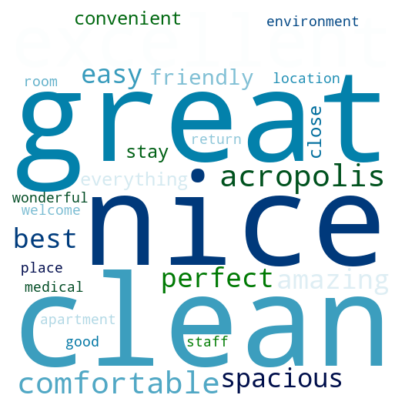

In [99]:
wordCloud_generator(' '.join(all_pos), 'white', 'ocean')

Negatives word cloud:

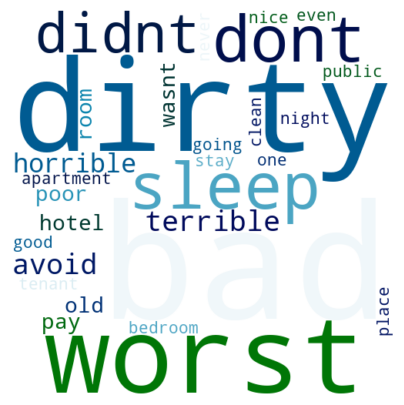

In [100]:
wordCloud_generator(' '.join(all_neg), 'white', 'ocean')

For the last visualization, we will plot the coordinates for each hotel the review is intended and colour it based on the deep learning models predictions

In [103]:
def make_map(dataset, lat, lng, preds, cmap='RdYlGn', s=15, vmin=0, vmax=1, alpha=.4, title="", xlim1=None, xlim2=None, ylim1=None, ylim2=None,savename='example.png'):
    # Geodata dataframe init
    gdf = gpd.GeoDataFrame(
        dataset,
        geometry=gpd.points_from_xy(dataset['location.lng'], dataset['location.lat']),
        crs="EPSG:4326"
    )

    # Convert data to align with OpenStreetMap
    gdf = gdf.to_crs(epsg=3857)
    
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    sc = ax.scatter(
        gdf.geometry.x,
        gdf.geometry.y,
        c=preds,
        cmap=cmap,
        s=s,
        vmin=vmin,
        vmax=vmax,
        alpha=alpha
    )

    # Map type for the plot background
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)

    # Color bar
    cbar = plt.colorbar(sc, ax=ax, orientation="vertical", label="Sentiment (0 = Negative, 1 = Positive)", shrink=.5)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    if xlim1 and xlim2:ax.set_xlim(xlim1,xlim2)
    if ylim1 and ylim2:ax.set_ylim(ylim1, ylim2)
    fig.savefig(savename)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


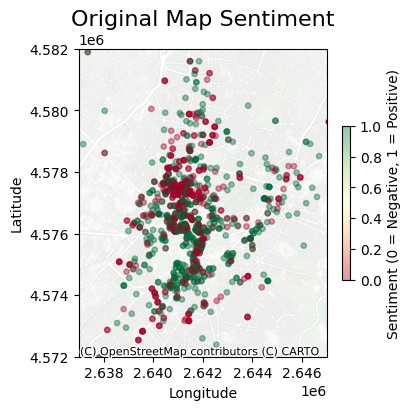

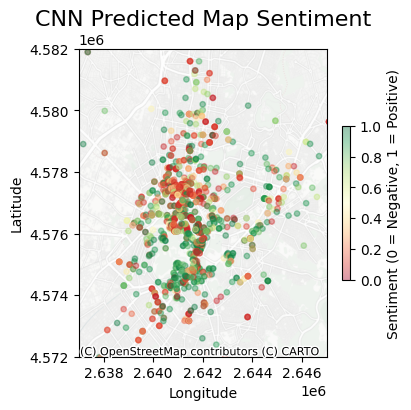

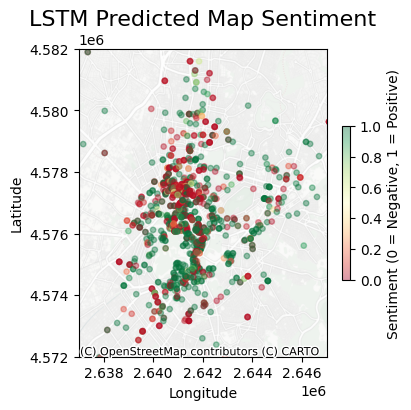

In [104]:
# Original map sentiment
make_map(dataset,dataset['location.lat'],dataset['location.lng'],dataset.encoded_sentiment,title="Original Map Sentiment",xlim1=2.637e6,xlim2=2.647e6,ylim1=4.572e6,ylim2=4.582e6, savename="original.png")

# Baseline models predicted sentiment map
# for i in range(len(classifiers)):
#     preds = classifiers[i].predict(np.asarray(vectorizer.transform(dataset.review_text_cleaned).todense()))
#     make_map(dataset,dataset['location.lat'],dataset['location.lng'],preds,title="Predicted Map Sentiment",xlim1=2.637e6,xlim2=2.647e6,ylim1=4.572e6,ylim2=4.582e6, savename=all_models_results.iloc[i].name)

# Deep learning models predicted sentiment map
temp = tokenizer.texts_to_sequences(dataset.review_text_cleaned)
preds = cnn_model.predict(sequence.pad_sequences(temp, maxlen=maxlen,padding='post',truncating='post'))
make_map(dataset,dataset['location.lat'],dataset['location.lng'],preds,savename="cnn.png",title="CNN Predicted Map Sentiment",xlim1=2.637e6,xlim2=2.647e6,ylim1=4.572e6,ylim2=4.582e6)

preds = lstm_model.predict(sequence.pad_sequences(temp, maxlen=maxlen,padding='post',truncating='post'))
make_map(dataset,dataset['location.lat'],dataset['location.lng'],preds,savename="lstm.png",title="LSTM Predicted Map Sentiment",xlim1=2.637e6,xlim2=2.647e6,ylim1=4.572e6,ylim2=4.582e6)

plt.show()

The models perform well and can distinguise positive, negative words and also identify domain specific sentiment words like acropolis, mould, dirty, clean. 

---

## References

A. Ameus, S. Hamdi and S. Ben Yahia, “Sentiment Analysis for Hotel Reviews: A Systematic Literature Review,” ACM Computing Surveys, vol. 56, no. 2, pp. 1-32, 2023.

Wikipedia, “Sentiment analysis,” Wikipedia, [Online]. Available: https://en.wikipedia.org/wiki/Sentiment_analysis. [Accessed 14 01 2025].

K. Sudhanshu, R. Partha Pratim , D. Prosad Dogra and K. Byung-Gyu , “A Comprehensive Review on Sentiment Analysis: Tasks, Approaches and Applications,” arXiv, 2023.

https://docs.seldon.io/projects/alibi/en/stable/examples/integrated_gradients_imdb.html

https://medium.com/@amalia.wulandiari/sentiment-analysis-hotel-review-python-nltk-846738de727f

---